# Inflation, Unemploymet and Real GDP

The goal of this project is to analyze the employment rates of men and women across various industries. We intend to present both the overall employment figures and highlight differences within specific sectors. Our objective is to identify sectors where one gender is predominant over the other and vice versa. Additionally, we aim to examine employment growth rates over time and assess how external factors, such as the 2020 pandemic, have impacted workforce dynamics. Through this analysis, we seek to gain insights into gender representation in the labor market and understand the effects of external events on employment trends.

Imports and load of relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import datetime
import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject as dp

#If you dont have the content below, remove the hashtag and install them

# pip install pandas-datareader
# %pip install git+https://github.com/alemartinello/dstapi
# %pip install pandas-datareader

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## Importing inflation data from Denmark Statistics

We consider the following dictionary definitions wrt. table PRIS111

In [2]:
columns_dict = {}
columns_dict['VAREGR'] = 'variable'
columns_dict['ENHED'] = 'unit'
columns_dict['TID'] = 'Year'
columns_dict['INDHOLD'] = 'Inflation rate'

var_dict = {} # var is for variable
var_dict['00 Consumer price index, total'] = 'Y'


unit_dict = {}
unit_dict['Index'] = 'Indexnumber'
unit_dict['Percentage change compared to previous month (per cent)'] = 'pct month'
unit_dict['Percentage change compared to same month the year before (per cent)'] = 'pct year'

In [3]:
# Importing inflation data via Api.  
PRIS111_api = DstApi('PRIS111') 
params = PRIS111_api._define_base_params(language='en')

PRIS111 = PRIS111_api.get_data(params)

In [4]:
# Renaming columns of the DataFrame PRIS111. 
PRIS111.rename(columns=columns_dict,inplace=True)

# Looping over the var dictionary.
for key,value in var_dict.items():
    PRIS111.variable.replace(key,value,inplace=True)

# Looping over the unit dictionary.
for key,value in unit_dict.items():
    PRIS111.unit.replace(key,value,inplace=True)


In [5]:
# Only keep rows where the variable is in `[Y]`. Afterwards convert the `value` column to a float.

# Ensuring 'year' is a string before applying string methods
PRIS111['Year'] = PRIS111['Year'].astype(str)

# Filter based on 'variable' values
var_vals = var_dict.values()
I_var = PRIS111['variable'].isin(var_vals)
PRIS111 = PRIS111[I_var]

# Grouping variables
# PRIS111.groupby(['variable','unit']).describe()

## Exploring data set

In [6]:
# Ensuring 'year' is a string before applying string methods
PRIS111['Year'] = PRIS111['Year'].astype(str)

# Filter based on 'variable' values
var_vals = var_dict.values()
I_var = PRIS111['variable'].isin(var_vals)
PRIS111 = PRIS111[I_var]

# Remove rows where 'unit' is either "Indexnumber" or "pct month"
units_to_exclude = ['Indexnumber', 'pct month']
I_unit = ~PRIS111['unit'].isin(units_to_exclude)
PRIS111 = PRIS111[I_unit]

# Filter to keep only rows where 'year' ends with "M12", then remove the "M12" part
I_year_suffix = PRIS111['Year'].str.endswith("M12")
PRIS111 = PRIS111[I_year_suffix]
PRIS111['Year'] = PRIS111['Year'].str.replace('M12', '')

# Convert 'year' back to integer for proper comparison and sorting
PRIS111['Year'] = PRIS111['Year'].astype(int)

# Exclude rows before "2007" and the year "2023"
PRIS111 = PRIS111[(PRIS111['Year'] >= 2007) & (PRIS111['Year'] != 2023)]

# Sort the DataFrame by 'year' in ascending order
PRIS111 = PRIS111.sort_values(by='Year')

# PRIS111


## Merge inflation- and unemployment data from Denmark Statistics

We merge with AULP01: Unemployment

In [7]:
FT_api = DstApi('AULP01')
params = FT_api._define_base_params(language='en')
params['variables'][0]['values'] = ['000']
params['variables'][1]['values'] = ['TOT']
params['variables'][2]['values'] = ['TOT']
params['variables'][3]['values'] = ['2007','2008','2009','2010','2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
## 000 is the code for all of Denmark, this can be seen by using: FT_api.variable_levels('HOVEDDELE', language='en')
unemp = FT_api.get_data(params=params)

unemp.rename(columns={'TID':'Year','INDHOLD':'Unemployment'},inplace=True)
unemp =  unemp.loc[:,['Year','Unemployment']]

In [8]:
# hint, merged = pd.merge(?,?,how='?',on=[?])
# merged_true.tail(10)

# Merge the DataFrames
#merged = pd.merge(PRIS111, unemp, how='left', on=['year'])

# Display the tail of the new DataFrame
# merged.tail(20)

# We merge our two dataframes inflation (PRIS111) and Unemployment (unemp)
merged = pd.merge(PRIS111, unemp, how='left', on='Year')

Combined_data = merged[['Year', 'Inflation rate', 'Unemployment']]

In [9]:
Combined_data.head(2)

,Year,Inflation rate,Unemployment
0,2007,2.3,3.6
1,2008,2.4,2.6


## Real GDP for Denmark

In [10]:
# Importing data from CSV file 'Real GDP'
GDP = pd.read_csv('GDP new1.csv',delimiter=';')

## Display the data set

In [11]:
#Here we display the data to see the values for Real GDP
GDP.head(10)

,Year,Real GDP
0,2007,1879.0
1,2008,1869.4
2,2009,1777.7
3,2010,1810.9
4,2011,1835.1
5,2012,1839.3
6,2013,1856.5
7,2014,1886.5
8,2015,1930.7
9,2016,1993.4


In [12]:
# We display our combined data for the inflation and unemployment rate. 
Combined_data.head(2)

,Year,Inflation rate,Unemployment
0,2007,2.3,3.6
1,2008,2.4,2.6


We combine all three dataframes Real GDP with inflation and unemployment rate

In [13]:
# We join/ merge our dataframe real GDP with our combined data which contains dataframe inflation and unemployment rate. 
merging = pd.merge(GDP, Combined_data, how='left', on=['Year'])

Combined_data1 = merging[["Year", "Inflation rate", "Unemployment", "Real GDP"]]
Combined_data1.head(10)

,Year,Inflation rate,Unemployment,Real GDP
0,2007,2.3,3.6,1879.0
1,2008,2.4,2.6,1869.4
2,2009,1.4,4.8,1777.7
3,2010,2.8,6.1,1810.9
4,2011,2.4,6.0,1835.1
5,2012,2.1,6.0,1839.3
6,2013,0.7,5.8,1856.5
7,2014,0.4,5.0,1886.5
8,2015,0.4,4.5,1930.7
9,2016,0.5,4.1,1993.4


In [14]:
#Printing to see what type it is, string or float?
type_ = GDP['Year'].dtype
type1_ = GDP['Real GDP'].dtype
print(type_,type1_)

int64 float64


In [15]:
# We convert 'Year' column to integer if it's stored as string
GDP['Year'] = pd.to_numeric(GDP['Year'], errors='coerce')
# Here we do the same converting column Real GDP to a numeric type
GDP['Real GDP'] = pd.to_numeric(GDP['Real GDP'], errors='coerce')

In [16]:
# Convert 'Year' column to integer if it's stored as string
Combined_data1['Year'] = pd.to_numeric(Combined_data1['Year'], errors='coerce')
# Convert other columns to numeric type
Combined_data1['Real GDP'] = pd.to_numeric(Combined_data1['Real GDP'], errors='coerce')
Combined_data1['Inflation rate'] = pd.to_numeric(Combined_data1['Inflation rate'], errors='coerce')
Combined_data1['Unemployment'] = pd.to_numeric(Combined_data1['Unemployment'], errors='coerce')


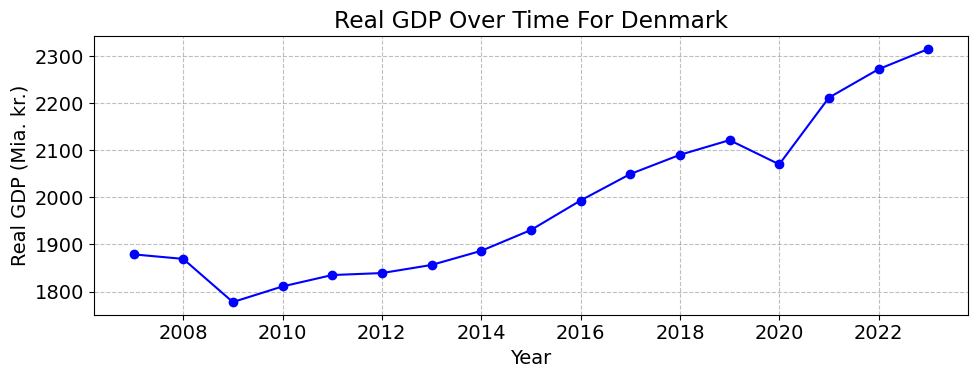

In [17]:
# We sort our DataFrame by the 'Year' column
GDP.sort_values(by='Year', inplace=True)

# Plotting the graph for Real GDP
plt.figure(figsize=(10, 4))
plt.plot(GDP['Year'], GDP['Real GDP'], marker='o', color='blue')
plt.ylabel('Real GDP (Mia. kr.)')
plt.title('Real GDP Over Time For Denmark')
plt.xlabel('Year')
plt.grid(True)  # Add gridlines
plt.tight_layout()
plt.show()

Describe what we see on the graph. 

## Analyzing the data

In [18]:
# Calculate average GDP
average_GDP = Combined_data1['Real GDP'].mean()

# Calculate maximum and minimum GDP
max_GDP = Combined_data1['Real GDP'].max()
min_GDP = Combined_data1['Real GDP'].min()

# Calculate average Unemployment Rate
average_unemp = Combined_data1['Unemployment'].mean()

# Calculate average Inflation Rate
average_inf = Combined_data1['Inflation rate'].mean()


# Print the results
print("Average GDP:", average_GDP)
print("Maximum GDP:", max_GDP)
print("Minimum GDP:", min_GDP)
print("Average Unemployment Rate:", average_unemp)
print("Average Inflation Rate:", average_inf)

Average GDP: 1988.805882352941
Maximum GDP: 2315.2
Minimum GDP: 1777.7
Average Unemployment Rate: 4.4312499999999995
Average Inflation Rate: 1.8937499999999998


Describe what wee see above regarding the results

In [19]:
#Calculating the correlation between Real GDP and Inflation
corr_GDP_inf = Combined_data1['Real GDP'].corr(Combined_data1['Inflation rate'])
print("Correlation between GDP and Inflation Rate:", corr_GDP_inf)

Correlation between GDP and Inflation Rate: 0.40999091926569303


In [20]:
#Calculate the correlation between Real GDP and unemployment rates.

corr_GDP_unemp = Combined_data1['Unemployment'].corr(Combined_data1['Real GDP'])

# Print the correlation coefficient
print("Correlation coefficient between Real GDP and Unemployment:", corr_GDP_unemp)

Correlation coefficient between Real GDP and Unemployment: -0.648567676353837


In [21]:
# Calculate the correlation between inflation rates and unemployment rates
corr_inf_unemp = Combined_data1['Inflation rate'].corr(Combined_data1['Unemployment'])

# Print the correlation coefficient
print("Correlation coefficient between Inflation rate and Unemployment rate:", corr_inf_unemp)

Correlation coefficient between Inflation rate and Unemployment rate: -0.3889069349704023


In [22]:
# Calculate the annual growth rate of GDP
GDP['GDP_growth'] = GDP['Real GDP'].pct_change() * 100  # Calculate percentage change in GDP

# Create a new DataFrame with Year and GDP Growth Rate
GDP_growth_ = pd.DataFrame({'Year': GDP['Year'], 'GDP_growth': GDP['GDP_growth']})

# Drop the first row since it will have NaN value for growth rate
GDP_growth_ = GDP_growth_.dropna()

# Print the DataFrame with Year and GDP Growth Rate
print(GDP_growth_)

    Year  GDP_growth
1   2008   -0.510910
2   2009   -4.905317
3   2010    1.867582
4   2011    1.336352
5   2012    0.228870
6   2013    0.935138
7   2014    1.615944
8   2015    2.342963
9   2016    3.247527
10  2017    2.819304
11  2018    1.990632
12  2019    1.492537
13  2020   -2.422700
14  2021    6.844749
15  2022    2.730684
16  2023    1.887955
